In [ ]:
pip install yellowbrick

In [1]:
# Import Packages 

import numpy as np 
import matplotlib.pyplot as plt

# implemented algorithms available in sklearn, in order to compare to our models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from yellowbrick.regressor import ResidualsPlot, cooks_distance

In [2]:
# Load variables
x_train_dataset = np.load('Xtrain_Regression2.npy');
y_train_dataset = np.load('Ytrain_Regression2.npy');
x_test = np.load('Xtest_Regression2.npy');

In [3]:
# check dimensions
print('X train dataset dimensions = ', x_train_dataset.shape)
print('Y train dataset dimensions = ', y_train_dataset.shape)
print('X test dataset dimensions = ', x_test.shape)

X train dataset dimensions =  (100, 10)
Y train dataset dimensions =  (100, 1)
X test dataset dimensions =  (1000, 10)


#### Pre-processing function

In [4]:
def pre_processing(x_train_dataset, y_train_dataset, center = True):
    
    if center:
        # defining a new set of coordinates that is located in 
        # the center of the data (zero mean) 
        Xdesign = x_train_dataset - np.mean(x_train_dataset, axis = 0) # design matrix
        Y = y_train_dataset - np.mean(y_train_dataset, axis = 0)
        
    else:
        Xdesign = np.append(np.ones((x_train_dataset.shape[0], 1)), x_train_dataset, axis = 1) # design matrix
        Y = y_train_dataset
        
    return Xdesign, Y

#### Estimation of the model's coefficients:

In [5]:
def Beta(X,y, center, *var_lambda, regularization = None):
    
    # preprocessing of the data: 
    Xdesign, Y = pre_processing(X,y, center) 
    
    # learning of the model, by minimizing the SSE
    if regularization == None:
        beta = np.linalg.pinv(Xdesign)@Y
        
    elif regularization == 'ridge':
        
        XT = np.transpose(Xdesign)
        
        beta = np.linalg.inv(XT@Xdesign + var_lambda*np.identity(Xdesign.shape[1]))@(XT@Y)
    
    elif regularization == 'lasso':
        lasso = Lasso(alpha=var_lambda[0], max_iter=10000, fit_intercept = ~center)
        lasso.fit(Xdesign, Y)
        beta = lasso.coef_[:, None]
    
    if center:
        # invert the pre-processing of centering the training data, in order to be applied to the non-centered test data 
        beta0_hat = np.mean(y, axis = 0) - np.mean(X, axis = 0)[None, :]@beta

        beta = np.append(beta0_hat, beta, axis = 0)
    
    return beta

#### Predictor function

In [6]:
def y_pred(X, beta): 
    
    # Design matrix, adding a column of 1s, representing the offset
    X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
    
    # linear combination of the features, plus the offset
    y_hat = X@beta 
    
    return y_hat

#### Error function

In [7]:
def Error(Y, y_pred):
    
    # the components of the vector Y-y_pred are the errors of 
    # each training example
    e = Y - y_pred 
    
    SSE = np.transpose(e)@e

    return SSE

#### Data Visualization functions

In [8]:
# Visualization of the data

def graphics(var_x, var_y, title, inliers_mask = np.array([]), graph_type = 'boxplot'):
    
    if graph_type == 'scatter_plot':
        fig, axs = plt.subplots(5, 2, figsize=(15, 20))
    
        for num_variable, ax in zip(range(var_x.shape[1]), axs.ravel()):
            ax.plot(var_x[:,num_variable], var_y, '*') 
        
            ax.set_xlabel('$x_n$')
            ax.set_ylabel('$y_n$')
            ax.set_title('Feature'+str(num_variable+1))
            plt.axis('tight') 
                        
        fig.suptitle(title, fontsize=18, y=0.9)
        plt.subplots_adjust(wspace=0.3,hspace=0.4)
        plt.show()
    
    if graph_type == 'boxplot':
        fig = plt.figure(figsize =(10, 7))
        
        # Creating plot
        bp = plt.boxplot(np.append(var_x, var_y, axis = 1))
        
        # show plot
        plt.show()
        
    if graph_type == 'tsne':
                
        X_embedded = TSNE(n_components=1, random_state = 1).fit_transform(var_x)

        plt.plot(X_embedded, var_y, 'g.', )
        plt.xlabel('1D Embedding of the Features X')
        plt.ylabel('y')
        plt.title(title)
        
        if inliers_mask.any():
            plt.plot(X_embedded[~inliers_mask, :], var_y[~inliers_mask, :], 'r.', label = 'outliers')
            plt.legend()
        
        plt.show()
        

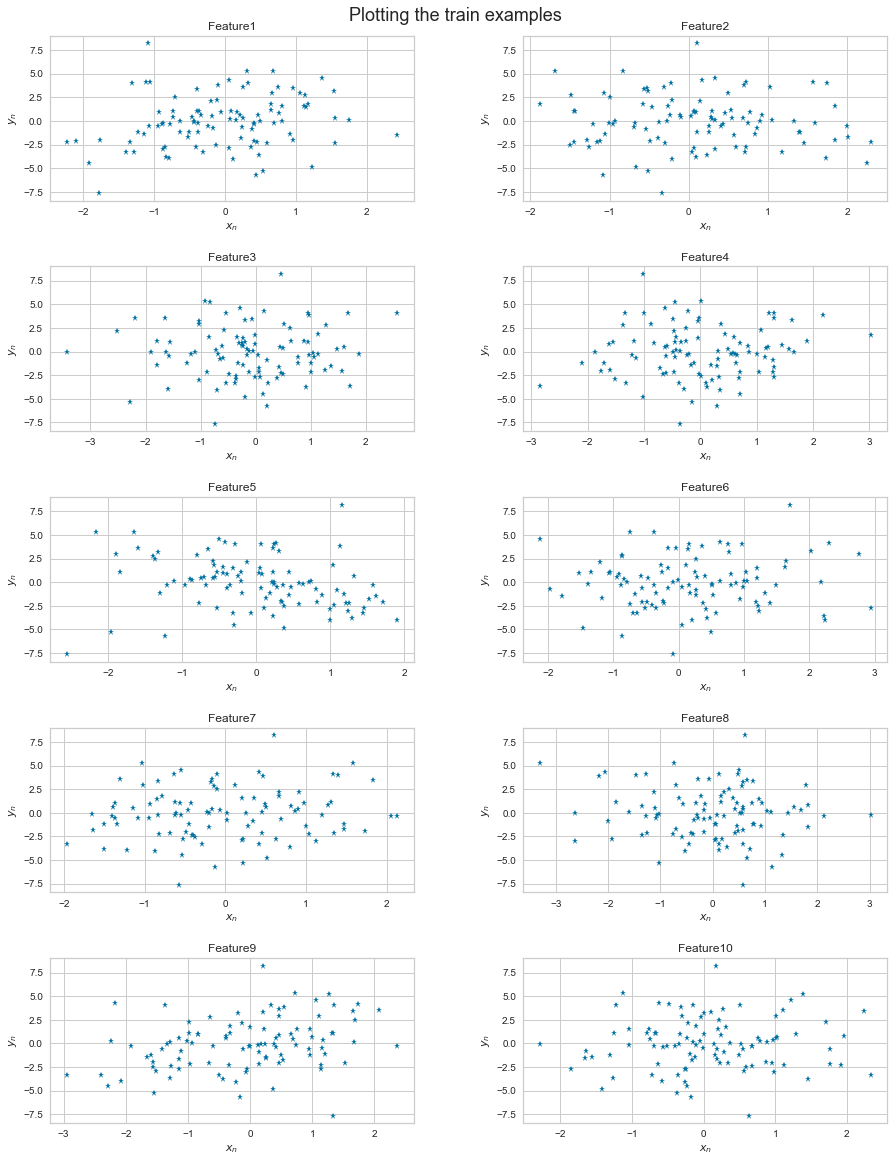

In [9]:
graphics(x_train_dataset, y_train_dataset, 'Plotting the train examples', graph_type = 'scatter_plot')

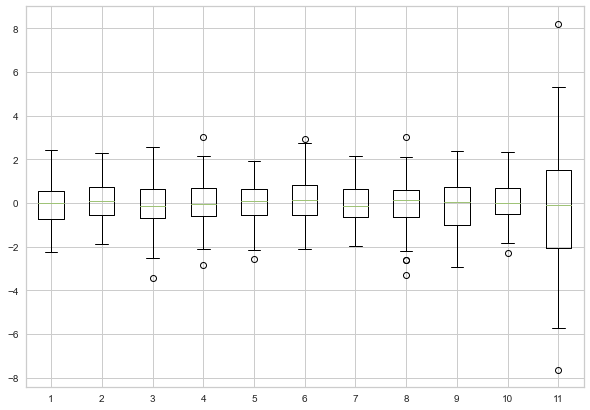

In [10]:
graphics(x_train_dataset, y_train_dataset, '', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


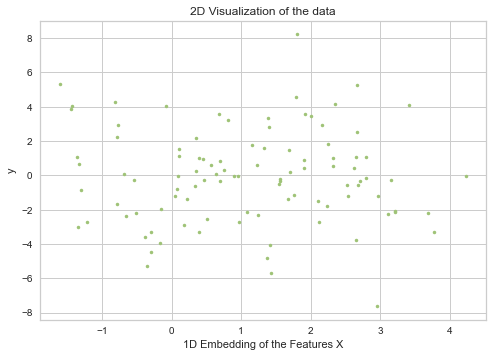

In [11]:
graphics(x_train_dataset, y_train_dataset, '2D Visualization of the data', graph_type = 'tsne')

#### Performance evaluation: Cross validation function

In [12]:
nfolds = 10
nrepeats = 3

def cross_val(model, X, Y, center, nfolds, nrepeats, *var_lambda):
    
    n_scores = []
    
    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state = 1)
    
    #rkf = KFold(n_splits = nfolds, shuffle = var_shuffle, random_state=1) 
    
    for train_index, test_index in rkf.split(X):
        Xtrain, Ytrain = X[train_index], Y[train_index]
        Xtest, Ytest = X[test_index], Y[test_index]
        
        SSE, _ = model(Xtrain, Ytrain, Xtest, Ytest, center, *var_lambda)
                
        n_scores.append(SSE)
    
    mean_scores = np.mean(n_scores)
    std_scores = np.std(n_scores)

    return mean_scores, std_scores

## Model 1. Simple linear regression

In [13]:
def lineareg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center):
    
    # learning of the model's coefficients, by minimizing the SSE
    beta = Beta(x_train_dataset, y_train_dataset, center)
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [14]:
center = True

n_scores_model1 = cross_val(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

#print(np.ravel(n_scores_model1[0]))
print('SSE: %f ± %f' % (n_scores_model1[0], n_scores_model1[1]))

SSE: 72.692408 ± 51.585506


#### Comparison with sklearn model (check if results are similar):

In [15]:
lin_reg = LinearRegression(fit_intercept = True)

# evaluate the model:
cv = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)
n_scores = cross_val_score(lin_reg, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# report model performance
print('SSE: %f ± %f' % (np.mean(nfolds*abs(n_scores)), np.std(nfolds*abs(n_scores))))

SSE: 72.692408 ± 51.585506


## Model 2. Ridge Regression

In [16]:
def ridgereg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):

    # learning of the model's coefficients
    beta = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'ridge')
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [19]:
#lambdas_ridge = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 

lambdas_ridge = np.arange(60, 71, 1) 

n_scores_model2_mean_all = []
n_scores_model2_std_all = []

center = True

for var_lambda in lambdas_ridge:
    n_scores_model2 = cross_val(ridgereg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model2_mean_all.append(n_scores_model2[0])
    n_scores_model2_std_all.append(n_scores_model2[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (n_scores_model2[0], n_scores_model2[1]))    
    
idx_best_ridge = np.argmin(n_scores_model2_mean_all)
lambda_best = lambdas_ridge[idx_best_ridge]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model2_mean_all[idx_best_ridge], n_scores_model2_std_all[idx_best_ridge]))

SSE, lambda = 60: 69.026451 ± 43.210954  
SSE, lambda = 61: 69.024825 ± 43.138366  
SSE, lambda = 62: 69.023773 ± 43.066932  
SSE, lambda = 63: 69.023270 ± 42.996625  
SSE, lambda = 64: 69.023293 ± 42.927420  
SSE, lambda = 65: 69.023821 ± 42.859292  
SSE, lambda = 66: 69.024832 ± 42.792217  
SSE, lambda = 67: 69.026306 ± 42.726172  
SSE, lambda = 68: 69.028225 ± 42.661133  
SSE, lambda = 69: 69.030569 ± 42.597081  
SSE, lambda = 70: 69.033322 ± 42.533991  
SSE of the best model, lambda = 63: 69.023270 ± 42.996625  


#### Comparison with sklearn model (check if results are similar):

In [20]:
#lambdas_ridge = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 

lambdas_ridge = np.arange(60, 71, 1) 

# evaluate the model:
cv = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)

n_scores_ridge_mean_all = []
n_scores_ridge_std_all = []

for var_lambda in lambdas_ridge: 
    ridge = Ridge(alpha = var_lambda, max_iter=10000)
    
    n_scores_ridge = cross_val_score(ridge, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    
    n_scores_ridge_mean_all.append(np.mean(nfolds*abs(n_scores_ridge)))
    n_scores_ridge_std_all.append(np.std(nfolds*abs(n_scores_ridge)))
    
    #report model performance
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (np.mean(nfolds*abs(n_scores_ridge)), np.std(nfolds*abs(n_scores_ridge)))) 
    
idx_best_ridge = np.argmin(n_scores_ridge_mean_all)
lambda_best = lambdas_ridge[idx_best_ridge]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_ridge_mean_all[idx_best_ridge], n_scores_ridge_std_all[idx_best_ridge]))

SSE, lambda = 60: 69.026451 ± 43.210954  
SSE, lambda = 61: 69.024825 ± 43.138366  
SSE, lambda = 62: 69.023773 ± 43.066932  
SSE, lambda = 63: 69.023270 ± 42.996625  
SSE, lambda = 64: 69.023293 ± 42.927420  
SSE, lambda = 65: 69.023821 ± 42.859292  
SSE, lambda = 66: 69.024832 ± 42.792217  
SSE, lambda = 67: 69.026306 ± 42.726172  
SSE, lambda = 68: 69.028225 ± 42.661133  
SSE, lambda = 69: 69.030569 ± 42.597081  
SSE, lambda = 70: 69.033322 ± 42.533991  
SSE of the best model, lambda = 63: 69.023270 ± 42.996625  


## Model 3. Lasso Regression

In [21]:
def lassoreg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):
    
    # learning of the model's coefficients. this can't be obtained analitically,
    # being an optimization problem
    beta = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'lasso')
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [22]:
lambdas_lasso = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
#lambdas_lasso = np.arange(0.01, 0.11, 0.01)
 
n_scores_model3_mean_all = []
n_scores_model3_std_all = []

center = True

for var_lambda in lambdas_lasso:
    n_scores_model3 = cross_val(lassoreg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model3_mean_all.append(n_scores_model3[0])
    n_scores_model3_std_all.append(n_scores_model3[1])
        
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (n_scores_model3[0], n_scores_model3[1]))
    
idx_best_lasso = np.argmin(n_scores_model3_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model3_mean_all[idx_best_lasso], n_scores_model3_std_all[idx_best_lasso]))

SSE, lambda = 0.001: 72.638327 ± 51.555924  
SSE, lambda = 0.01: 72.174306 ± 51.283977  
SSE, lambda = 0.1: 69.261189 ± 48.646672  
SSE, lambda = 1: 75.265907 ± 35.302586  
SSE, lambda = 10: 74.785931 ± 34.953011  
SSE, lambda = 20: 74.785931 ± 34.953011  
SSE, lambda = 30: 74.785931 ± 34.953011  
SSE, lambda = 40: 74.785931 ± 34.953011  
SSE, lambda = 50: 74.785931 ± 34.953011  
SSE, lambda = 60: 74.785931 ± 34.953011  
SSE, lambda = 70: 74.785931 ± 34.953011  
SSE, lambda = 80: 74.785931 ± 34.953011  
SSE, lambda = 90: 74.785931 ± 34.953011  
SSE, lambda = 100: 74.785931 ± 34.953011  
SSE of the best model, lambda = 0.1: 69.261189 ± 48.646672  


#### Comparison with sklearn model (check if results are similar):

In [23]:
# evaluate the model:
lambdas_lasso = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 

var_shuffle = True 

cv = RepeatedKFold(n_splits=nfolds, n_repeats = nrepeats, random_state=1)

n_scores_lasso_mean_all = []
n_scores_lasso_std_all = []

for var_lambda in lambdas_lasso: 
    lasso = Lasso(alpha = var_lambda, max_iter=10000)
    
    n_scores_lasso = cross_val_score(lasso, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    
    n_scores_lasso_mean_all.append(np.mean(nfolds*abs(n_scores_lasso)))
    n_scores_lasso_std_all.append(np.std(nfolds*abs(n_scores_lasso)))
    
    # report model performance
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (np.mean(nfolds*abs(n_scores_lasso)), np.std(nfolds*abs(n_scores_lasso))))    
    
idx_best_lasso = np.argmin(n_scores_lasso_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_lasso_mean_all[idx_best_lasso], n_scores_lasso_std_all[idx_best_lasso]))

SSE, lambda = 0.001: 72.638327 ± 51.555924  
SSE, lambda = 0.01: 72.174306 ± 51.283977  
SSE, lambda = 0.1: 69.261189 ± 48.646672  
SSE, lambda = 1: 75.265907 ± 35.302586  
SSE, lambda = 10: 74.785931 ± 34.953011  
SSE, lambda = 20: 74.785931 ± 34.953011  
SSE, lambda = 30: 74.785931 ± 34.953011  
SSE, lambda = 40: 74.785931 ± 34.953011  
SSE, lambda = 50: 74.785931 ± 34.953011  
SSE, lambda = 60: 74.785931 ± 34.953011  
SSE, lambda = 70: 74.785931 ± 34.953011  
SSE, lambda = 80: 74.785931 ± 34.953011  
SSE, lambda = 90: 74.785931 ± 34.953011  
SSE, lambda = 100: 74.785931 ± 34.953011  
SSE of the best model, lambda = 0.1: 69.261189 ± 48.646672  


## Model 4. Linear Regression after Feature Selection with Lasso

In [24]:
# function that performs linear regression only on the features selected by lasso, for a given lambda

def lineareg_lasso_dropout(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):
    
    # estimation of the lasso model's coefficients
    beta_lasso = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'lasso')
    
    # check coefficients that are 0 
    deleted_features = np.asarray(np.where(beta_lasso == 0))
    
    deleted_features_list = []
    
    # remove the unimportant features determined by lasso
    for idx in range(deleted_features.shape[1]):
        
        # subtract by 1 since beta_lasso contains an additional parameter, the offset
        feature = deleted_features[0,idx] - 1 
        
        deleted_features_list.append(feature)
        
    x_train_dataset_new = np.delete(x_train_dataset, deleted_features_list, 1)        
    x_test_dataset_new = np.delete(x_test_dataset, deleted_features_list, 1)
        
    # learning of the model's coefficients, by minimizing the SSE
    beta = Beta(x_train_dataset_new, y_train_dataset, center)
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset_new, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [25]:
lambdas_lasso_dropout = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 

center = True

n_scores_model4_mean_all = []
n_scores_model4_std_all = []

for var_lambda in lambdas_lasso_dropout:
    n_scores_model4 = cross_val(lineareg_lasso_dropout, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model4_mean_all.append(n_scores_model4[0])
    n_scores_model4_std_all.append(n_scores_model4[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f' % (n_scores_model4[0], n_scores_model4[1]))

idx_best_lasso = np.argmin(n_scores_model4_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model4_mean_all[idx_best_lasso], n_scores_model4_std_all[idx_best_lasso]))
                                                                               

SSE, lambda = 0.001: 72.692591 ± 51.585501
SSE, lambda = 0.01: 72.686868 ± 51.590709
SSE, lambda = 0.1: 71.433574 ± 51.057382
SSE, lambda = 1: 79.648623 ± 38.757784
SSE, lambda = 10: 74.785931 ± 34.953011
SSE, lambda = 20: 74.785931 ± 34.953011
SSE, lambda = 30: 74.785931 ± 34.953011
SSE, lambda = 40: 74.785931 ± 34.953011
SSE, lambda = 50: 74.785931 ± 34.953011
SSE, lambda = 60: 74.785931 ± 34.953011
SSE, lambda = 70: 74.785931 ± 34.953011
SSE, lambda = 80: 74.785931 ± 34.953011
SSE, lambda = 90: 74.785931 ± 34.953011
SSE, lambda = 100: 74.785931 ± 34.953011
SSE of the best model, lambda = 0.1: 71.433574 ± 51.057382  


## Model 5. Stepwise Feature Selection 

In [28]:
# function that performs stepwise-elimination of the features, appying a linear regression model to them, if it improves the performance of the model

def feature_dropout(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    features_dropout = []
    
    prev_mean, prev_std = cross_val(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)
    
    rkf = RepeatedKFold(n_splits=nfolds, n_repeats = nrepeats, random_state=1)
    
    # deletes features stepwise and progressively
    for feature in range(x_train_dataset.shape[1]):
        features_dropout.append(feature)
                
        x_train_dataset_new = np.delete(x_train_dataset, features_dropout, 1)
        
        current_mean, current_std = cross_val(lineareg_model, x_train_dataset_new, y_train_dataset, center, nfolds, nrepeats)
        
        if current_mean >= prev_mean:
            features_dropout.remove(feature)
        else:
            prev_mean = current_mean 
            prev_std = current_std
    
    print('Dropout Features: {}'.format(features_dropout))
    
    return prev_mean, prev_std

In [29]:
center = True

n_score_model5 = feature_dropout(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)
print('SSE: %f ± %f' % (n_score_model5[0], n_score_model5[1]))

Dropout Features: [1, 2, 3, 5, 6, 7, 9]
SSE: 65.214342 ± 49.553456


## Model 6. Huber regression

In [30]:
def huber_regression(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon):
    
    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1) 
        
    n_scores = []
    
    for train_index, test_index in rkf.split(x_train_dataset):
        Xtrain, Ytrain = x_train_dataset[train_index], y_train_dataset[train_index]
        Xtest, Ytest = x_train_dataset[test_index], y_train_dataset[test_index]
        
        huber = HuberRegressor(epsilon = var_epsilon, alpha = var_alpha, fit_intercept = ~center).fit(Xtrain, Ytrain.ravel())
        
        y_hat = huber.predict(Xtest)

        SSE = Error(Ytest.ravel(), y_hat)
        
        n_scores.append(SSE)
        
        outliers = huber.outliers_
        
    n_scores_mean = np.mean(n_scores)
    n_scores_std = np.std(n_scores)
    
    return n_scores_mean, n_scores_std, ~outliers, np.sum(outliers.astype(int))
        

In [37]:
#alphas_huber = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alphas_huber = np.arange(20, 31, 1)
epsilons_huber = [1.8] # controls the number of samples that should be classified as outliers

center = False 

n_scores_model6_mean_all = []
n_scores_model6_std_all = []

performances_huber = []

for var_epsilon in epsilons_huber:
    for var_alpha in alphas_huber:
        n_score_model6_mean, n_score_model6_std, inliers_mask, num_outliers = huber_regression(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)
    
        n_scores_model6_mean_all.append(n_score_model6_mean)
        n_scores_model6_std_all.append(n_score_model6_std)
        
        performances_huber.append((n_score_model6_mean, var_epsilon, var_alpha, inliers_mask, num_outliers))        
        
        print('SSE, alpha = '+ str(var_alpha) + ': %f ± %f' % (n_score_model6_mean, n_score_model6_std))
        print('Detected outliers:', num_outliers)


print(min(performances_huber, key = lambda p: p[0]))

SSE, alpha = 20: 67.476735 ± 53.932120
Detected outliers: 13
SSE, alpha = 21: 67.302300 ± 53.230739
Detected outliers: 13
SSE, alpha = 22: 67.147140 ± 52.553558
Detected outliers: 13
SSE, alpha = 23: 67.012802 ± 51.901815
Detected outliers: 13
SSE, alpha = 24: 66.913818 ± 51.302579
Detected outliers: 13
SSE, alpha = 25: 66.841805 ± 50.738555
Detected outliers: 12
SSE, alpha = 26: 66.789003 ± 50.201777
Detected outliers: 11
SSE, alpha = 27: 66.752406 ± 49.697585
Detected outliers: 11
SSE, alpha = 28: 66.731759 ± 49.228954
Detected outliers: 11
SSE, alpha = 29: 66.721594 ± 48.787537
Detected outliers: 11
SSE, alpha = 30: 66.718446 ± 48.365336
Detected outliers: 12
(66.71844554372942, 1.8, 30, array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,

## Model 7. Huber combined with Stepwise Feature Selector

In [34]:
def feature_dropout_huber(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon):
    
    features_dropout = []
    
    prev_mean, prev_std, _, _ = huber_regression(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)
    
    n = x_train_dataset.shape[0]
    
    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1) 
    
    # deletes features stepwise and progressively
    for feature in range(x_train_dataset.shape[1]):
        features_dropout.append(feature)
                
        x_train_dataset_new = np.delete(x_train_dataset, features_dropout, 1)
        
        current_mean, current_std, inliers_mask, num_outliers = huber_regression(x_train_dataset_new, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)
        
        if current_mean >= prev_mean:
            features_dropout.remove(feature)
        else:
            prev_mean = current_mean 
            prev_std = current_std
            updated_inliers_mask = inliers_mask
            updated_num_outliers = num_outliers
    
    print('Dropout Features: {}'.format(features_dropout))
    
    return prev_mean, prev_std, updated_inliers_mask, updated_num_outliers

In [35]:
center = False

epsilons_huber = [1.6] 
#alphas_huber = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alphas_huber = np.arange(20, 31, 1)

n_scores_model7_mean_all = []
n_scores_model7_std_all = []

performances_huber = []

for var_epsilon in epsilons_huber:
    for var_alpha in alphas_huber:
        n_score_model7_mean, n_score_model7_std, inliers_mask, num_outliers = feature_dropout_huber(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)

        n_scores_model7_mean_all.append(n_score_model7_mean)
        n_scores_model7_std_all.append(n_score_model7_std)
        
        performances_huber.append((n_score_model7_mean, var_epsilon, var_alpha, inliers_mask, num_outliers))        
        
        print('SSE, alpha = '+ str(var_alpha) + ': %f ± %f' % (n_score_model7_mean, n_score_model7_std))
        print('Detected outliers:', num_outliers)

print(min(performances_huber, key = lambda p: p[0]))


Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 20: 61.714272 ± 45.362513
Detected outliers: 20
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 21: 61.707881 ± 45.065048
Detected outliers: 20
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 22: 61.710910 ± 44.776917
Detected outliers: 20
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 23: 61.721229 ± 44.496369
Detected outliers: 20
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 24: 61.739478 ± 44.224615
Detected outliers: 20
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 25: 61.766097 ± 43.963894
Detected outliers: 18
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 26: 61.799529 ± 43.712379
Detected outliers: 18
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 27: 61.839392 ± 43.467924
Detected outliers: 17
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 28: 61.886750 ± 43.233103
Detected outliers: 17
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 29: 61.940495 ± 43.007428
Detected outliers: 17
Dropout Features: [1, 2, 3, 5, 9]
SSE, alpha = 30:

## Model 8. Hubber for Outlier Deletion

In [38]:
def huber_outliers_deletion(model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon, *var_lambda):
                
    # Calculate the huber regression parameters
    huber = HuberRegressor(epsilon = var_epsilon, alpha=var_alpha, fit_intercept = ~center).fit(x_train_dataset, y_train_dataset.ravel())

    # Identify the outliers
    outliers = huber.outliers_
    num_outliers = np.sum(outliers.astype(int))
    
    inliers = ~outliers
    
    # Remove the outliers from the training sets       
    X_train, Y_train =  x_train_dataset[inliers, :], y_train_dataset[inliers]
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(model, X_train, Y_train, center, nfolds, nrepeats, *var_lambda)
    
    return n_scores_mean, n_scores_std, inliers, num_outliers
     

### linear regression 

In [39]:
alphas_huber = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epsilons_huber = [1.8]
center = False

performances_huber = []

for var_epsilon in epsilons_huber:
    for var_alpha in alphas_huber: 
        n_scores_model8_mean, n_scores_model8_std, inliers_mask_model8, num_outliers = huber_outliers_deletion(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)
        
        performances_huber.append((n_scores_model8_mean, var_epsilon, var_alpha, inliers_mask_model8, num_outliers))        
        
        print('SSE, alpha = ' + str(var_alpha)+': %f ± %f' % (n_scores_model8_mean, n_scores_model8_std))
        print('Detected outliers:', num_outliers)

print(min(performances_huber, key = lambda p: p[0]))

SSE, alpha = 0.001: 0.091953 ± 0.050308
Detected outliers: 20
SSE, alpha = 0.01: 0.091953 ± 0.050308
Detected outliers: 20
SSE, alpha = 0.1: 0.091953 ± 0.050308
Detected outliers: 20
SSE, alpha = 1: 0.091953 ± 0.050308
Detected outliers: 20
SSE, alpha = 10: 0.486286 ± 0.724076
Detected outliers: 18
SSE, alpha = 20: 3.525854 ± 3.404203
Detected outliers: 14
SSE, alpha = 30: 4.947836 ± 4.949438
Detected outliers: 15
SSE, alpha = 40: 4.947836 ± 4.949438
Detected outliers: 15
SSE, alpha = 50: 6.441728 ± 5.673172
Detected outliers: 14
SSE, alpha = 60: 6.441728 ± 5.673172
Detected outliers: 14
SSE, alpha = 70: 9.034136 ± 10.699719
Detected outliers: 13
SSE, alpha = 80: 9.193255 ± 7.365489
Detected outliers: 14
SSE, alpha = 90: 13.101132 ± 12.463392
Detected outliers: 13
SSE, alpha = 100: 16.456605 ± 13.083316
Detected outliers: 12
(0.09195292321417292, 1.8, 0.001, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  Tr

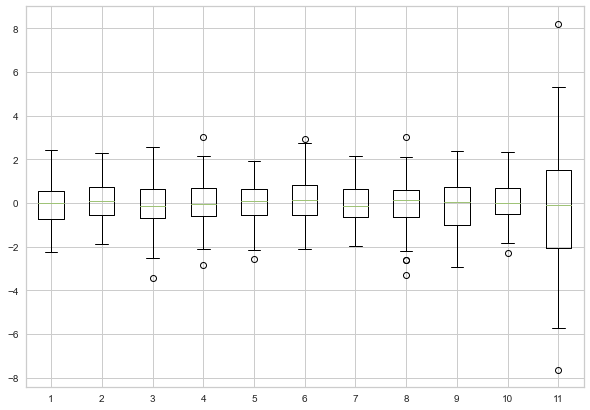

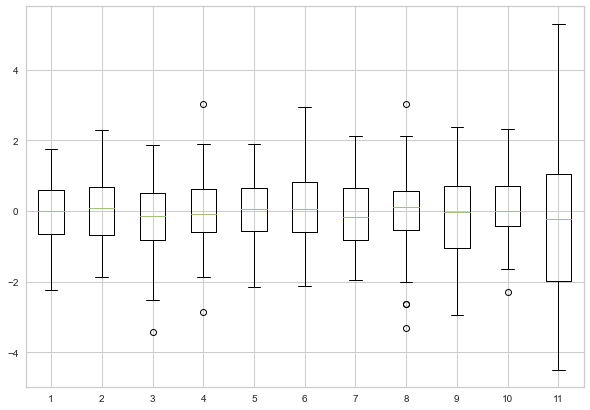

In [40]:
var_alpha = 0.1
var_epsilon =1.8

n_score_model8_mean, n_score_model8_std, inliers_mask_model8, num_outliers = huber_outliers_deletion(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon)

graphics(x_train_dataset, y_train_dataset, 'Raw dataset', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model8, :], y_train_dataset[inliers_mask_model8, :], 'After Outlier Removal', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


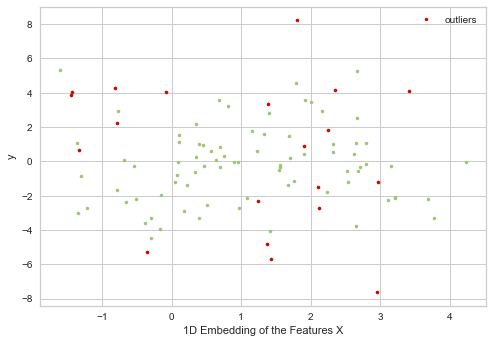

In [41]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model8, graph_type = 'tsne')

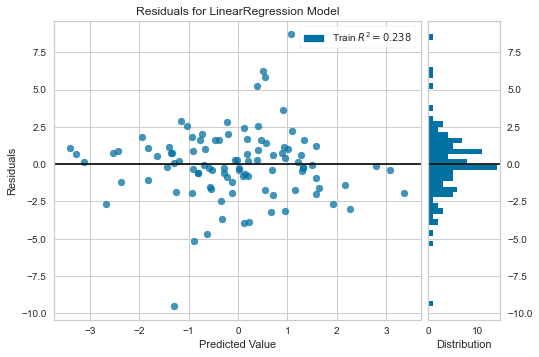

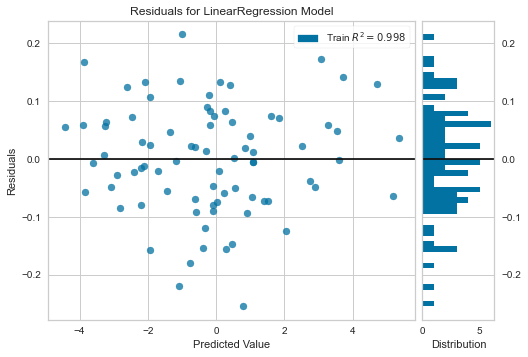

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [42]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model8, :], y_train_dataset[inliers_mask_model8, :].ravel())
visualizer_residuals.show()

### ridge

In [44]:
lambdas_ridge = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#lambdas_ridge = np.arange(0.01, 0.11, 0.01)
#alphas_huber = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alphas_huber = [0.01]
epsilons_huber = [1.8]

n_scores_model9_parameters = []

for var_epsilon in epsilons_huber:
    for var_alpha in alphas_huber:
        for var_lambda in lambdas_ridge:
            
            n_scores_model9_mean, n_scores_model9_std, inliers_mask_model9, num_outliers = huber_outliers_deletion(ridgereg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon, var_lambda)

            n_scores_model9_parameters.append((n_scores_model9_mean, var_lambda, var_alpha, var_epsilon,inliers_mask_model9, num_outliers))
            
            print('SSE, lambda = ' + str(var_lambda)+': %f ± %f' % (n_scores_model9_mean, n_scores_model9_std))
            print('Detected outliers:', num_outliers)
        
print(min(n_scores_model9_parameters, key = lambda p: p[0]))

SSE, lambda = 0.001: 0.091953 ± 0.050310
Detected outliers: 20
SSE, lambda = 0.01: 0.091959 ± 0.050337
Detected outliers: 20
SSE, lambda = 0.1: 0.092109 ± 0.050643
Detected outliers: 20
SSE, lambda = 1: 0.102619 ± 0.057551
Detected outliers: 20
SSE, lambda = 10: 0.852187 ± 0.508264
Detected outliers: 20
SSE, lambda = 20: 2.386152 ± 1.397914
Detected outliers: 20
SSE, lambda = 30: 4.141092 ± 2.369015
Detected outliers: 20
SSE, lambda = 40: 5.901690 ± 3.307143
Detected outliers: 20
SSE, lambda = 50: 7.582396 ± 4.175494
Detected outliers: 20
SSE, lambda = 60: 9.152080 ± 4.965915
Detected outliers: 20
SSE, lambda = 70: 10.603455 ± 5.681048
Detected outliers: 20
SSE, lambda = 80: 11.939733 ± 6.327319
Detected outliers: 20
SSE, lambda = 90: 13.168496 ± 6.912077
Detected outliers: 20
SSE, lambda = 100: 14.298827 ± 7.442449
Detected outliers: 20
(0.09195344632954323, 0.001, 0.01, 1.8, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True

### lasso

In [45]:
lambdas_lasso = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#alphas_huber = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alphas_huber = [0.1]
epsilons_huber = [1.8]

n_scores_model10_parameters = []

for var_epsilon in epsilons_huber:
    for var_alpha in alphas_huber:
        for var_lambda in lambdas_lasso:

            n_scores_model10_mean, n_scores_model10_std, inliers_mask_model10, num_outliers = huber_outliers_deletion(lassoreg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_alpha, var_epsilon, var_lambda)

            n_scores_model10_parameters.append((n_scores_model10_mean, var_lambda, var_alpha, var_epsilon, inliers_mask_model10, num_outliers))
            
            print('SSE, lambda = ' + str(var_lambda)+': %f ± %f' % (n_scores_model10_mean, n_scores_model10_std))
            print('Detected outliers:', num_outliers)
            
print(min(n_scores_model10_parameters, key = lambda p: p[0]))

SSE, lambda = 0.001: 0.090509 ± 0.048454
Detected outliers: 20
SSE, lambda = 0.01: 0.092815 ± 0.049779
Detected outliers: 20
SSE, lambda = 0.1: 0.678893 ± 0.355232
Detected outliers: 20
SSE, lambda = 1: 29.824828 ± 15.472706
Detected outliers: 20
SSE, lambda = 10: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 20: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 30: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 40: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 50: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 60: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 70: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 80: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 90: 38.679535 ± 17.619415
Detected outliers: 20
SSE, lambda = 100: 38.679535 ± 17.619415
Detected outliers: 20
(0.0905094894500004, 0.001, 0.1, 1.8, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  Tr

## Model 11. Ransac

In [46]:
def RANSAC_model(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state = 1)
    
    n_scores = []
    
    for train_index, test_index in rkf.split(x_train_dataset):
        Xtrain, Ytrain = x_train_dataset[train_index], y_train_dataset[train_index]
        Xtest, Ytest = x_train_dataset[test_index], y_train_dataset[test_index]
    
        ransac = RANSACRegressor().fit(Xtrain, Ytrain)
        y_hat = ransac.predict(Xtest)
        
        SSE = Error(Ytest, y_hat)
        
        n_scores.append(SSE)
        
    n_scores_mean = np.mean(n_scores)
    n_scores_std = np.std(n_scores)
    
    return n_scores_mean, n_scores_std

In [47]:
center = False 

n_scores_model11_mean, n_scores_model11_std = RANSAC_model(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model11_mean, n_scores_model11_std))

SSE: 76.420523 ± 71.709731


## Model 12. RANSAC Outlier Elimination

In [48]:
def RANSAC_outlier_deletion(model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, *var_lambda):
    
    # Calculate the huber regression parameters
    ransac = RANSACRegressor(random_state = 1).fit(x_train_dataset, y_train_dataset)
    
    # Identify the outliers
    inliers = ransac.inlier_mask_
    outliers = ~inliers
    
    num_outliers = np.sum(outliers.astype(int))
        
    # Remove the outliers from the training sets       
    X_train, Y_train =  x_train_dataset[inliers, :], y_train_dataset[inliers]
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(model, X_train, Y_train, center, nfolds, nrepeats, *var_lambda)
    
    return n_scores_mean, n_scores_std, inliers, num_outliers
    

### linear regression

In [49]:
n_scores_model12_mean, n_scores_model12_std, inliers_mask_model12, num_outliers = RANSAC_outlier_deletion(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model12_mean, n_scores_model12_std))
print('Number of outliers: ', num_outliers)


SSE: 1.639901 ± 2.046020
Number of outliers:  16


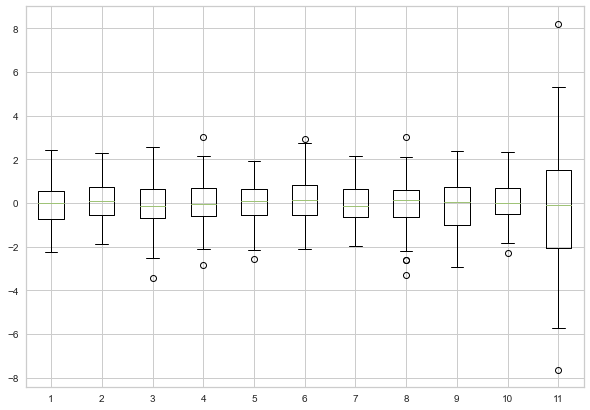

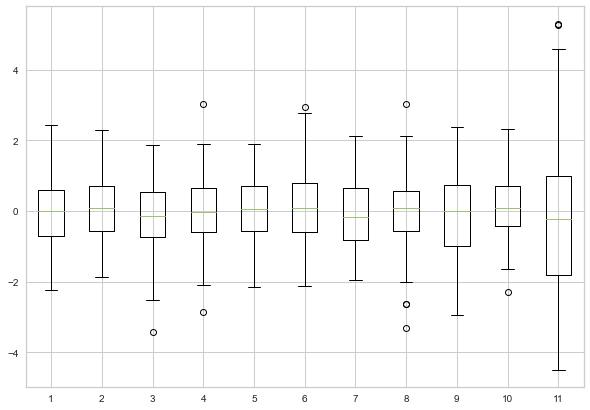

In [50]:
n_scores_model12_mean, n_scores_model12_std, inliers_mask, num_outliers = RANSAC_outlier_deletion(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

graphics(x_train_dataset, y_train_dataset, 'Raw dataset', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model12, :], y_train_dataset[inliers_mask_model12, :], 'After Outlier Removal', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


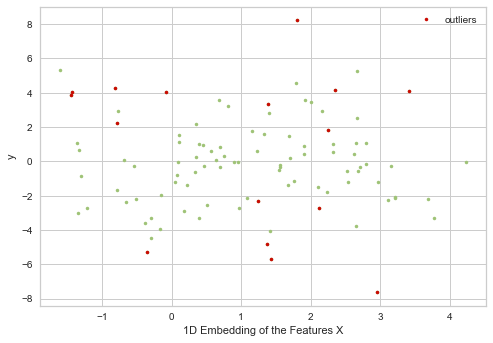

In [51]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model12, graph_type = 'tsne')

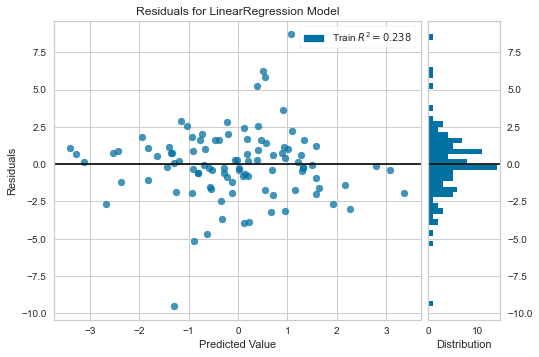

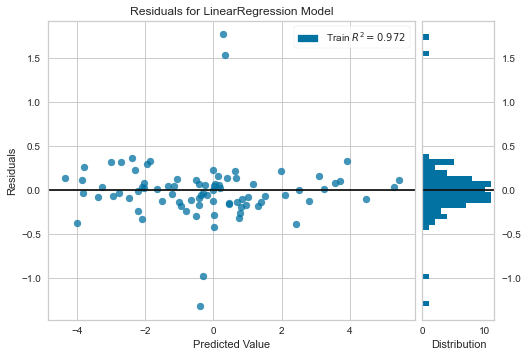

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [52]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model12, :], y_train_dataset[inliers_mask_model12, :].ravel())
visualizer_residuals.show()

### Ridge Regression

In [53]:
#lambdas_ridge = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lambdas_ridge = np.arange(0.1, 1.01, 0.1)

n_scores_model13_parameters = []

for var_lambda in lambdas_ridge:
    n_scores_model13_mean, n_scores_model13_std, inliers_mask_model13, num_outliers = RANSAC_outlier_deletion(ridgereg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)

    n_scores_model13_parameters.append((n_scores_model13_mean, var_lambda, inliers_mask_model13, num_outliers))

    print('SSE, lambda = ' + str(var_lambda)+': %f ± %f' % (n_scores_model13_mean, n_scores_model13_std))
    print('Detected outliers:', num_outliers)
        
print(min(n_scores_model13_parameters, key = lambda p: p[0]))


SSE, lambda = 0.1: 1.638095 ± 2.042641
Detected outliers: 16
SSE, lambda = 0.2: 1.636501 ± 2.039310
Detected outliers: 16
SSE, lambda = 0.30000000000000004: 1.635119 ± 2.036023
Detected outliers: 16
SSE, lambda = 0.4: 1.633946 ± 2.032782
Detected outliers: 16
SSE, lambda = 0.5: 1.632980 ± 2.029585
Detected outliers: 16
SSE, lambda = 0.6: 1.632219 ± 2.026430
Detected outliers: 16
SSE, lambda = 0.7000000000000001: 1.631660 ± 2.023316
Detected outliers: 16
SSE, lambda = 0.8: 1.631302 ± 2.020244
Detected outliers: 16
SSE, lambda = 0.9: 1.631142 ± 2.017212
Detected outliers: 16
SSE, lambda = 1.0: 1.631178 ± 2.014219
Detected outliers: 16
(1.6311419776062779, 0.9, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  Tru

### Lasso Regression 

In [54]:
lambdas_lasso = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#lambdas_lasso = np.arange(0.001, 0.011, 0.001)
 
n_scores_model14_parameters = []

for var_lambda in lambdas_lasso:
    n_scores_model14_mean, n_scores_model14_std, inliers_mask_model14, num_outliers = RANSAC_outlier_deletion(lassoreg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)

    n_scores_model14_parameters.append((n_scores_model14_mean, var_lambda, inliers_mask_model14, num_outliers))

    print('SSE, lambda = ' + str(var_lambda)+': %f ± %f' % (n_scores_model14_mean, n_scores_model14_std))
    print('Detected outliers:', num_outliers)
    
print(min(n_scores_model14_parameters, key = lambda p: p[0]))

SSE, lambda = 0.001: 1.619329 ± 2.030827
Detected outliers: 16
SSE, lambda = 0.01: 1.606623 ± 2.028259
Detected outliers: 16
SSE, lambda = 0.1: 2.159676 ± 2.037769
Detected outliers: 16
SSE, lambda = 1: 32.569467 ± 15.484508
Detected outliers: 16
SSE, lambda = 10: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 20: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 30: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 40: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 50: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 60: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 70: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 80: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 90: 39.174421 ± 16.518546
Detected outliers: 16
SSE, lambda = 100: 39.174421 ± 16.518546
Detected outliers: 16
(1.606623169202179, 0.01, array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  

## Model 15. Theil-Sen Regression

In [55]:
def Theil_Sen(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)
        
    n_scores = []
    
    for train_index, test_index in rkf.split(x_train_dataset):
        Xtrain, Ytrain = x_train_dataset[train_index], y_train_dataset[train_index]
        Xtest, Ytest = x_train_dataset[test_index], y_train_dataset[test_index]
        
        theil = TheilSenRegressor().fit(Xtrain, Ytrain.ravel())
        
        y_hat = theil.predict(Xtest)

        SSE = Error(Ytest.ravel(), y_hat)
        
        n_scores.append(SSE)
                
    n_scores_mean = np.mean(n_scores)
    n_scores_std = np.std(n_scores)
    
    return n_scores_mean, n_scores_std

In [56]:
n_scores_theil_mean, n_scores_theil_std = Theil_Sen(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_theil_mean, n_scores_theil_std))

SSE: 70.456329 ± 62.794286


## Model 16. Isolation Forest

In [57]:
def isolation_forest(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    # identify outliers in the training dataset
    iso = IsolationForest(contamination=0.16)
    yhat = iso.fit_predict(x_train_dataset) # select all rows that are not outliers
    
    outliers = yhat == -1
    mask = yhat != -1
    
    X_train, Y_train = x_train_dataset[mask, :], y_train_dataset[mask]
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(lineareg_model, X_train, Y_train, center, nfolds, nrepeats)
    
    return n_scores_mean, n_scores_std, mask, np.sum(outliers.astype(int))

In [58]:
center = False 

n_scores_model16_mean, n_scores_model16_std, inliers_mask_model16, num_outliers = isolation_forest(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model16_mean, n_scores_model16_std))
print('Detected outliers:', num_outliers)

SSE: 69.995217 ± 47.099954
Detected outliers: 16


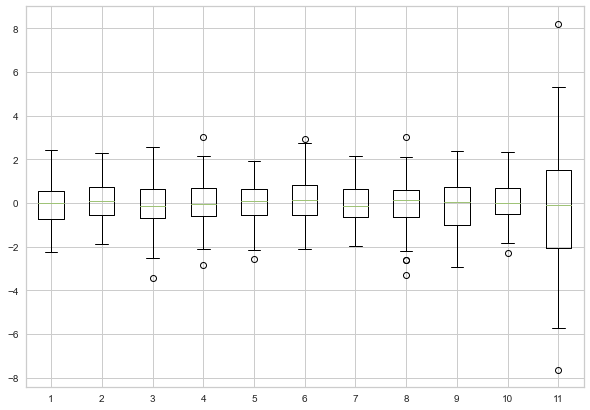

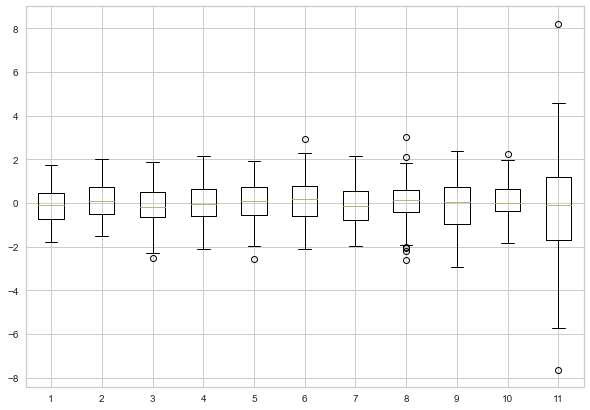

In [59]:
graphics(x_train_dataset, y_train_dataset, '', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model16, :], y_train_dataset[inliers_mask_model16, :], '', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


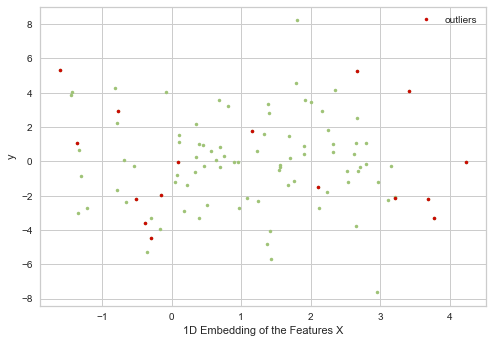

In [60]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model16, graph_type = 'tsne')

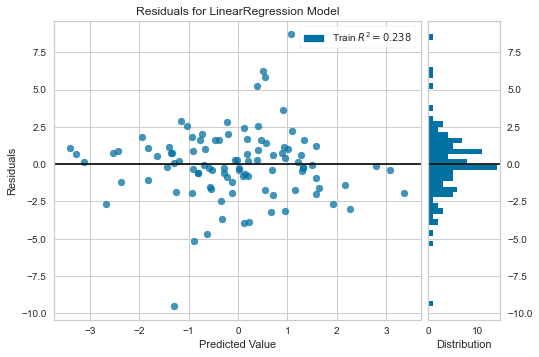

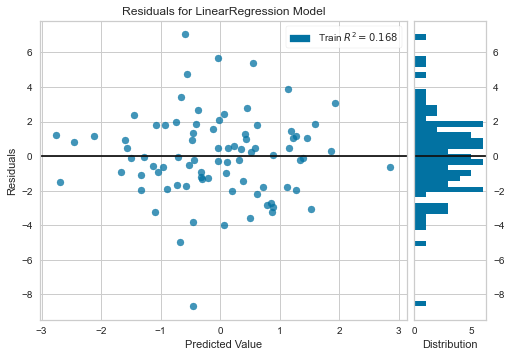

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [61]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model16, :], y_train_dataset[inliers_mask_model16, :].ravel())
visualizer_residuals.show()

## Model 17. Local Outlier Factor

In [62]:
def lof_function(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    # identify outliers in the training dataset
    lof = LocalOutlierFactor(n_neighbors=10, contamination=0.2)
    yhat = lof.fit_predict(x_train_dataset)
    
    # select all rows that are not outliers
    outliers = yhat == -1
    mask = yhat != -1
    X_train, Y_train = x_train_dataset[mask, :], y_train_dataset[mask]
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(lineareg_model, X_train, Y_train, center, nfolds, nrepeats)
    
    # plot graph
    plt.figure(1, (15,10))
    X_scores = lof.negative_outlier_factor_
    X_embedded = TSNE(n_components=1).fit_transform(x_train_dataset)
    
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X_embedded, y_train_dataset, color="k", s=3.0, label="Data points")
    
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    plt.scatter(
        X_embedded,
        y_train_dataset,
        s=1000 * radius,
        edgecolors="r",
        facecolors="none",
        label="Outlier scores",
    )
    plt.axis("tight")

    legend = plt.legend(loc="upper left")
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

    return n_scores_mean, n_scores_std, mask, np.sum(outliers.astype(int))

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


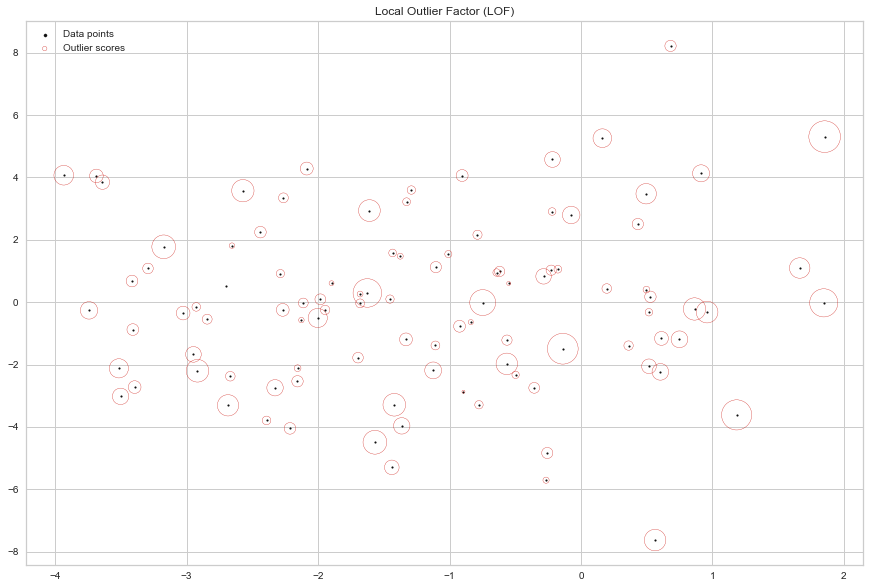

SSE: 59.100764 ± 35.549514
Detected outliers: 20


In [63]:
center = False 

n_scores_model17_mean, n_scores_model17_std, inliers_mask_model17, num_outliers = lof_function(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model17_mean, n_scores_model17_std))
print('Detected outliers:', num_outliers)


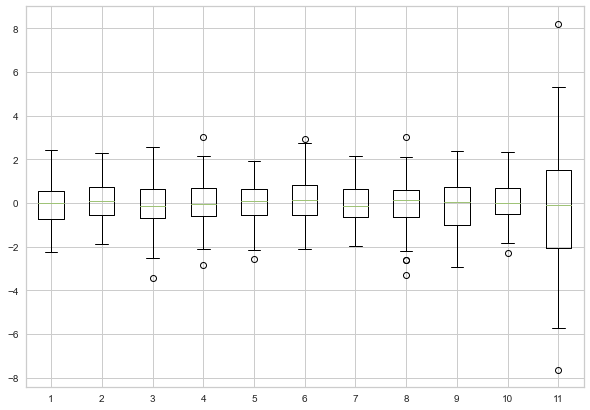

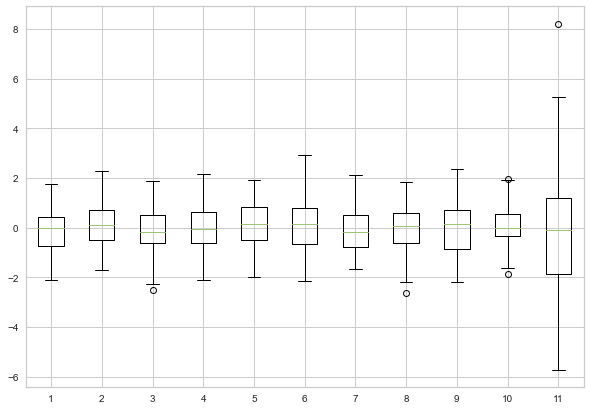

In [64]:
graphics(x_train_dataset, y_train_dataset, '', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model17, :], y_train_dataset[inliers_mask_model17, :], '', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


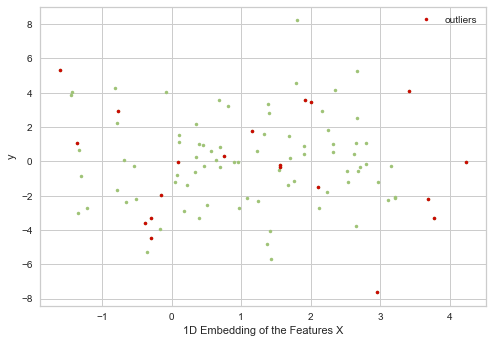

In [65]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model17, graph_type = 'tsne')

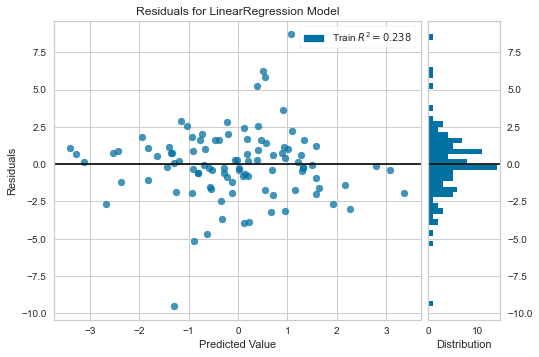

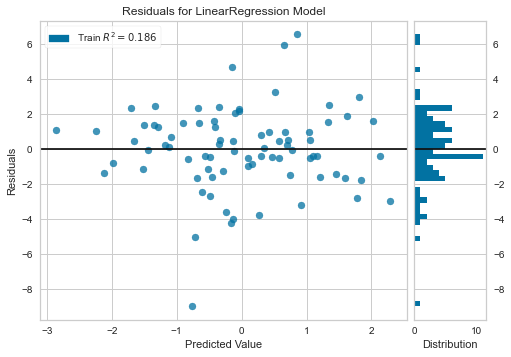

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model17, :], y_train_dataset[inliers_mask_model17, :].ravel())
visualizer_residuals.show()

## Model 18. IQR Outlier Detection

In [67]:
def outlier_treatment(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    data = np.append(x_train_dataset, y_train_dataset, axis = 1)
    
    Q1,Q3 = np.percentile(data , [25,75], axis=0)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    
    inliers = [True]*data.shape[0]
    
    for i in range(data.shape[1]):
        idx = ~((data[:, i] < lower_range[i]) | (data[:, i] > upper_range[i]))
        
        inliers = inliers * idx
    
    data_inliers = data[inliers]
    X_train = data_inliers[:, 0:data.shape[1]-1]
    Y_train = data_inliers[:, -1]
    
    outliers = ~inliers
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(lineareg_model, X_train, Y_train, center, nfolds, nrepeats)
    
    return n_scores_mean, n_scores_std, inliers_mask, np.sum(outliers.astype(int))

In [72]:
n_scores_model18_mean, n_scores_model18_std, inliers_mask_model18, num_outliers = outlier_treatment(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model18_mean, n_scores_model18_std))
print('Detected outliers:', num_outliers)


SSE: 46.025814 ± 31.834215
Detected outliers: 10


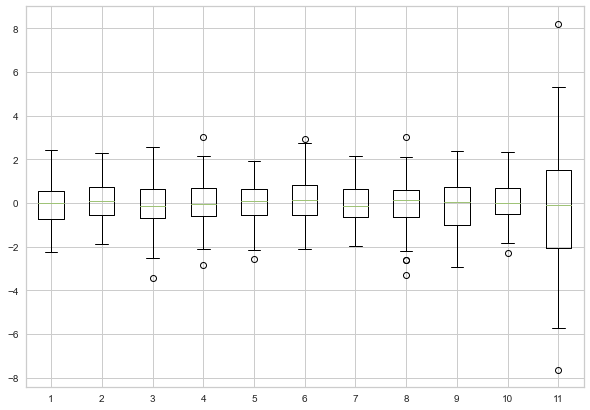

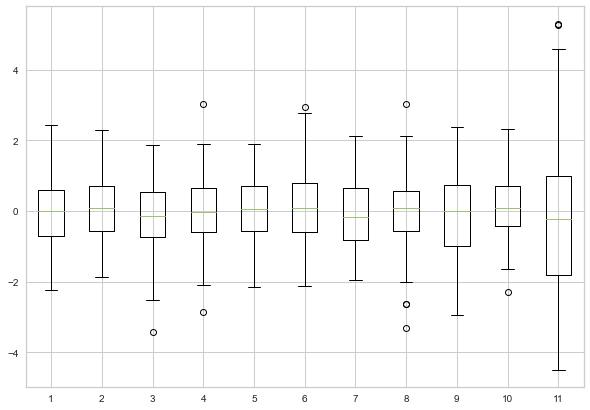

In [73]:
graphics(x_train_dataset, y_train_dataset, '', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model18, :], y_train_dataset[inliers_mask_model18, :], '', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


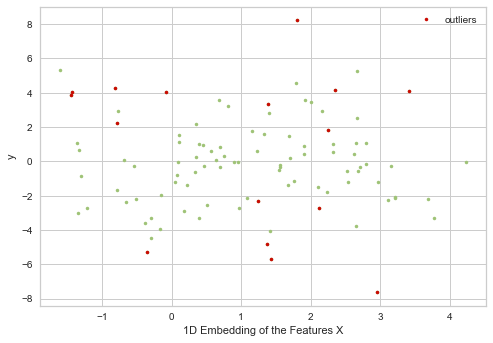

In [74]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model18, graph_type = 'tsne')

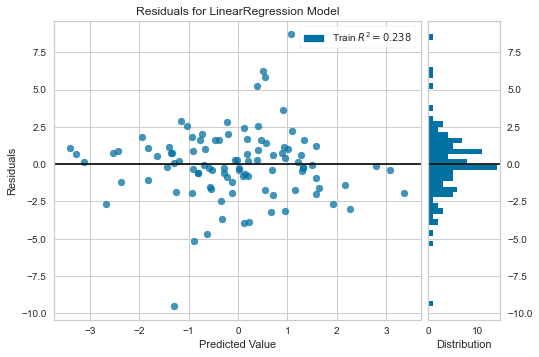

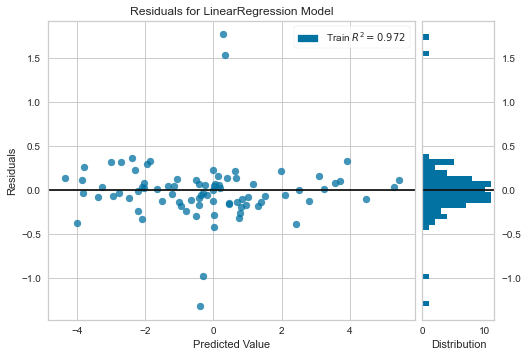

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [75]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model18, :], y_train_dataset[inliers_mask_model18, :].ravel())
visualizer_residuals.show()

## Model 19. Cook's Distance

In [76]:
def cooks_outlir_detection(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    # Instantiate and fit the visualizer
    cooks = cooks_distance(x_train_dataset, y_train_dataset.ravel(),draw_threshold=True,linefmt="C0-", markerfmt=",")

    cooks_distances = cooks.distance_
    cooks_thereshold = cooks.influence_threshold_
    cooks_outliers = cooks.outlier_percentage_

    inliers_mask = cooks_distances <= cooks_thereshold
    
    X_train, Y_train = x_train_dataset[inliers_mask, :], y_train_dataset[inliers_mask]
    
    # Perform Linear Regression
    n_scores_mean, n_scores_std = cross_val(lineareg_model, X_train, Y_train, center, nfolds, nrepeats)
    
    return n_scores_mean, n_scores_std, inliers_mask, cooks_thereshold

In [77]:
n_scores_model19_mean, n_scores_model19_std, inliers_mask_model19, num_outliers = outlier_treatment(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model19_mean, n_scores_model19_std))
print('Detected outliers:', num_outliers)


SSE: 46.025814 ± 31.834215
Detected outliers: 10


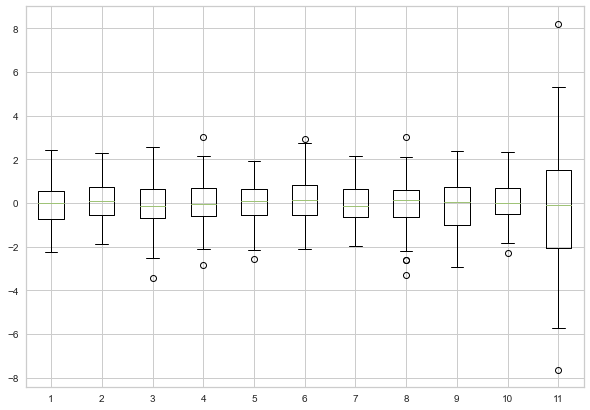

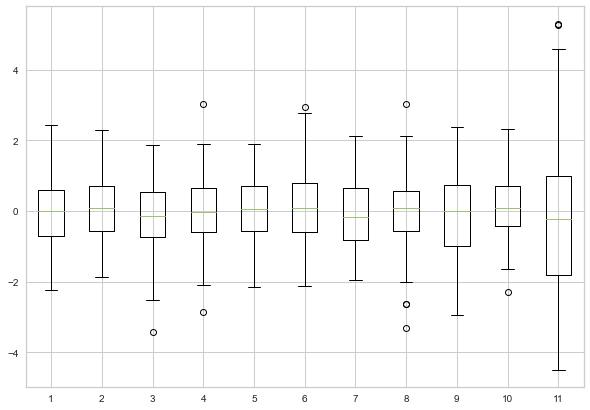

In [78]:
graphics(x_train_dataset, y_train_dataset, '', graph_type = 'boxplot')
graphics(x_train_dataset[inliers_mask_model19, :], y_train_dataset[inliers_mask_model19, :], '', graph_type = 'boxplot')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


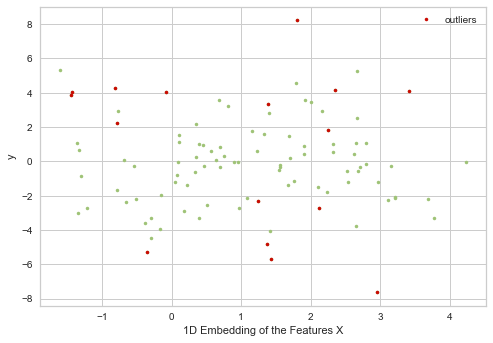

In [79]:
graphics(x_train_dataset, y_train_dataset, '', inliers_mask = inliers_mask_model19, graph_type = 'tsne')

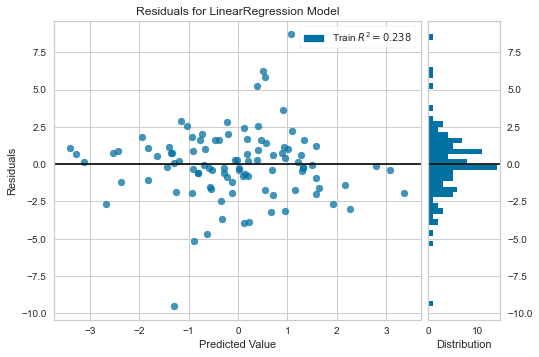

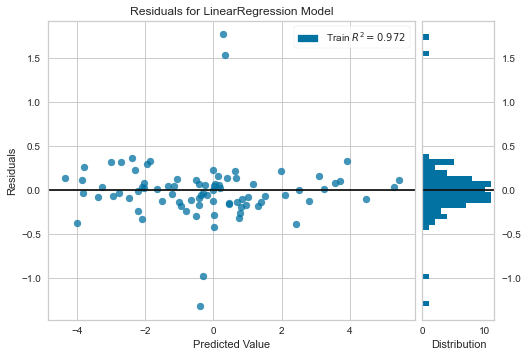

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [80]:
visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset, y_train_dataset.ravel())
visualizer_residuals.show()

visualizer_residuals = ResidualsPlot(LinearRegression())
visualizer_residuals.fit(x_train_dataset[inliers_mask_model19, :], y_train_dataset[inliers_mask_model19, :].ravel())
visualizer_residuals.show()

## Conclusions

After evaluating the models' performances, the lasso regression after outlier removal with Huber regression stands-out as being the best model, given the input data. Therefore, this model was the selected one for computing the test set predictions:

In [81]:
x_train_dataset = np.load('Xtrain_Regression2.npy')
y_train_dataset = np.load('Ytrain_Regression2.npy')
x_test = np.load('Xtest_Regression2.npy')

center = True

var_lambda = 0.001
var_alpha = 0.1
var_epsilon = 1.8


# Calculate the huber regression parameters
huber = HuberRegressor(epsilon = var_epsilon, alpha=var_alpha).fit(x_train_dataset, y_train_dataset.ravel())

# Identify the outliers
outliers = huber.outliers_
num_outliers = np.sum(outliers.astype(int))
print(num_outliers)

inliers = ~outliers

# Remove the outliers from the training sets       
X_train, Y_train =  x_train_dataset[inliers, :], y_train_dataset[inliers]

beta = Beta(X_train, Y_train, center, var_lambda, regularization = 'lasso')

y_hat = y_pred(x_test, beta)

print(y_hat)
np.save("y_hat.npy", y_hat)

20
[[-2.56598127e+00]
 [-3.83217766e-02]
 [-4.99721611e-02]
 [-1.26269544e-01]
 [-2.77257237e+00]
 [-4.12024698e+00]
 [-1.45421840e+00]
 [ 7.75011965e-01]
 [-3.45636073e-01]
 [ 2.39900522e+00]
 [-2.18101354e+00]
 [ 3.65374219e+00]
 [ 2.39666266e+00]
 [-9.64002862e-01]
 [ 1.19840926e+00]
 [-2.74670351e+00]
 [ 9.83102907e-01]
 [ 4.36075416e-01]
 [ 8.97288270e-01]
 [ 4.65122533e+00]
 [-2.19905283e+00]
 [ 2.85510011e-01]
 [-3.30507702e+00]
 [-3.70645243e-01]
 [-1.15277460e+00]
 [ 5.63279742e-01]
 [-4.19742521e+00]
 [-3.42572429e-01]
 [ 5.22848127e-01]
 [-2.34444275e+00]
 [ 1.41369450e+00]
 [-3.31452212e+00]
 [-5.27145861e-01]
 [-1.00184486e+00]
 [-4.61188901e-01]
 [ 5.21614485e-01]
 [ 5.46392223e+00]
 [ 4.51865900e+00]
 [-2.33527925e+00]
 [ 2.67500236e+00]
 [ 3.33787688e+00]
 [-6.21907954e-01]
 [ 2.31245688e+00]
 [ 2.22014607e-01]
 [ 9.06762335e-02]
 [ 2.11802549e-01]
 [-1.45317148e+00]
 [-1.41104924e+00]
 [-3.62366380e-01]
 [ 1.71294812e+00]
 [ 1.12871336e-01]
 [-2.14825736e+00]
 [-1.6040